In [34]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

def complex_mvn_logpdf(z, Gamma):
    """Log-pdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    sign, logdet = jnp.linalg.slogdet(Gamma)

    # z: (L, K), Gamma_inv: (K, K)
    # Compute quadratic form for each row: zᵢᴴ Γ⁻¹ zᵢ
    quad = jnp.real(jnp.einsum("bi,ij,bj->b", jnp.conj(z), Gamma_inv, z))  # shape (L,)

    return -K * jnp.log(jnp.pi) - logdet - quad

In [36]:
import numpy as np

def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

z_obs, Gamma_true = simulate_cscn_data(K=5, n_samples=100)


In [37]:
# Empirical covariance
Gamma_emp = np.einsum("li,lj->ij", z_obs, np.conj(z_obs)) / z_obs.shape[0]

# Eigendecomposition (since Gamma_emp is Hermitian)
eigvals, U = np.linalg.eigh(Gamma_emp)  # U ∈ ℂ^{K×K}


In [38]:
eigvals

array([ 0.52255922,  1.32865944,  4.51649957, 10.20296191, 26.13588073])

In [39]:
z_obs.shape
empirical = jnp.einsum('lk,lj->lkj', z_obs, z_obs.conj()).mean(0)
eigvals, _ = jnp.linalg.eigh(empirical)


In [40]:
print(eigvals[::-1])
eigvals_true, _ = jnp.linalg.eigh(Gamma_true)
print(eigvals_true[::-1])

[26.135883   10.20296     4.516503    1.3286582   0.52255875]
[27.415787  10.522855   4.862656   1.4245313  0.6142037]


In [41]:
K = 5
-5 + (3*jnp.arange(K)[::-1])

Array([ 7,  4,  1, -2, -5], dtype=int32)

In [42]:
def model(z_obs):
    L, K = z_obs.shape

    # Diagonal variance (latent spectrum)
    log_sigma2 = numpyro.sample("log_sigma2", dist.Normal(-5.0, 1.0).expand([K]))
    sigma2 = jnp.exp(log_sigma2)
    D = jnp.diag(sigma2)

    # Basis matrix
    B_real = numpyro.sample("B_real", dist.Normal(0, 1).expand([K, K]))
    B_imag = numpyro.sample("B_imag", dist.Normal(0, 1).expand([K, K]))
    B = B_real + 1j * B_imag

    # Covariance
    Gamma = B @ D @ B.conj().T

    # Likelihood
    logp = complex_mvn_logpdf(z_obs, Gamma)
    numpyro.factor("likelihood", jnp.sum(logp))


In [43]:
from jax.random import PRNGKey

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(PRNGKey(0), z_obs=jnp.array(z_obs))
posterior = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:12<00:00, 124.08it/s, 127 steps of size 3.34e-02. acc. prob=0.88]


In [44]:
# print(jnp.exp(posterior['log_sigma2']))
print((posterior['B_real'] + 1j*posterior['B_imag']))
Bs = posterior['B_real'] + 1j*posterior['B_imag']
Ds = jnp.exp(posterior['log_sigma2'])


# print(jnp.exp((posterior['log_tau'])))
# print(jnp.exp((posterior['log_lambda'])))

[[[ 0.09751736+1.39697754e+00j -0.8454708 +1.66349504e-02j
    0.32170078-5.17340779e-01j  1.4074996 +1.30253053e+00j
    1.5249697 -2.53516793e-01j]
  [-1.7556823 +6.89290345e-01j -1.4816637 +4.14229125e-01j
   -1.0538303 -3.81210208e-01j -0.60339516-2.04693794e+00j
    0.74240696+2.51005459e+00j]
  [ 0.5564915 +1.57310951e+00j  3.1134098 +2.21958742e-01j
   -1.9059949 +1.56850014e-02j  1.2107279 -1.84023246e-01j
   -0.25723496+3.08569819e-01j]
  [ 0.01744653-3.16701722e+00j  0.15721826-5.28039970e-02j
   -0.33509222+1.27628005e+00j -0.08453741+1.11831403e+00j
    2.3314548 -1.22232461e+00j]
  [-1.0936655 -1.51397753e+00j -0.53462523-1.05925035e+00j
   -1.9168152 +2.16014552e+00j -0.82344383+1.46241903e+00j
   -1.8471675 +5.37782669e-01j]]

 [[-0.5396977 +6.03469610e-01j -0.63641745-1.67915657e-01j
    0.99421364+9.83249605e-01j -0.5318031 -2.01620650e+00j
   -0.02952604-7.54159093e-02j]
  [ 0.50026375-4.33966428e-01j  2.204185  -2.65758514e+00j
    0.7468148 +1.96464312e+00j  0.76837

In [51]:
BBHs = jnp.stack([Bs[i].conj().T @ Bs[i] for i in range(1000)])

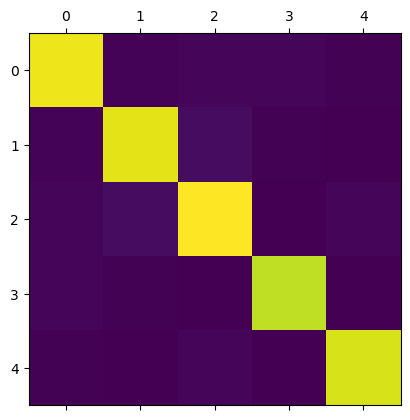

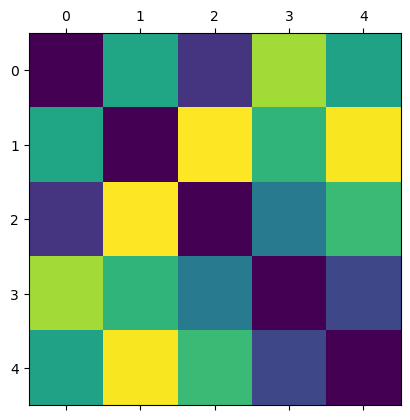

In [56]:
plt.matshow(BBHs.mean(0).real)
plt.matshow(jnp.abs(BBHs.mean(0).imag))

In [63]:
n = 0
i = 0
j = 1

(5, 5)

In [66]:
Ds.shape

(1000, 5)

In [69]:
Ds

Array([[0.53706723, 0.26925772, 1.2592835 , 0.05766007, 0.15724678],
       [1.1768868 , 0.06061705, 0.5790231 , 0.10004476, 0.39403751],
       [0.64777297, 0.13005888, 1.4791361 , 0.11249235, 0.23775272],
       ...,
       [0.14918396, 0.5254629 , 0.21706586, 0.15543874, 1.270044  ],
       [0.23497646, 0.75205976, 0.11058988, 0.3254627 , 0.5186693 ],
       [0.14099078, 1.6449866 , 0.42323306, 0.06384458, 1.1201243 ]],      dtype=float32)

In [72]:

Ds2 = Ds.copy()
Ds2 = Ds2.at[:,2:].set(0)

In [73]:
Gamma_samples = jnp.stack([Bs[i] @ jnp.diag(Ds2[i]) @ Bs[i].conj().T for i in range(1000)])

In [75]:
res = []
for i in range(1000):
    eigvals, _ = jnp.linalg.eigh(Gamma_samples[i,:,:])
    res.append(eigvals)



In [77]:
eigs, _ = jnp.linalg.eigh(Gamma_samples.mean(0))

In [78]:
eigs

Array([0.20498993, 0.557629  , 1.8695633 , 4.403619  , 9.45236   ],      dtype=float32)

In [76]:
res

[Array([-8.8854603e-07, -5.7056507e-08,  1.7036959e-06,  2.8774655e+00,
         1.2681740e+01], dtype=float32),
 Array([-5.4128907e-07,  2.0245720e-07,  2.7527947e-06,  1.1438651e+00,
         2.0423855e+01], dtype=float32),
 Array([-6.9242725e-07,  3.6945738e-07,  8.5940803e-07,  1.3238355e+00,
         1.4189060e+01], dtype=float32),
 Array([-1.6523674e-07, -3.3536288e-08,  1.0332363e-06,  1.7252957e+00,
         1.3071156e+01], dtype=float32),
 Array([-7.4942579e-07,  4.0662975e-08,  4.7034351e-07,  4.4372683e+00,
         1.1932807e+01], dtype=float32),
 Array([3.6374729e-08, 3.7927779e-07, 7.1683490e-07, 5.0159841e+00,
        1.0093886e+01], dtype=float32),
 Array([-9.7975283e-07,  7.9520674e-08,  3.0418238e-07,  6.2775340e+00,
         9.0338907e+00], dtype=float32),
 Array([-2.7620382e-07,  4.0132733e-09,  5.0315759e-07,  1.7306473e+00,
         9.2390537e+00], dtype=float32),
 Array([-4.1235802e-07,  2.9297121e-07,  1.9075173e-06,  5.4194684e+00,
         7.5008926e+00], dtyp

In [48]:
print(Gamma_samples.mean(0))
print(Gamma_true)

[[ 2.4561994 -4.5215715e-10j  1.0200052 -1.0596044e+00j
  -0.2615171 +1.9547137e+00j -3.094351  +2.5819477e-01j
  -3.9376388 -5.4956722e-01j]
 [ 1.0200052 +1.0596043e+00j  5.697983  +1.6801061e-09j
   0.76792634+3.0278194e+00j -1.9456897 -3.8747564e-01j
   0.9207509 +2.2040913e-01j]
 [-0.2615171 -1.9547137e+00j  0.76792634-3.0278194e+00j
   9.142247  -2.1895394e-09j -1.251354  +3.8787439e+00j
   2.775083  +6.0167861e+00j]
 [-3.094351  -2.5819477e-01j -1.9456897 +3.8747561e-01j
  -1.2513541 -3.8787439e+00j  9.308415  -2.5853515e-09j
   6.8516936 +7.1090364e-01j]
 [-3.9376388 +5.4956722e-01j  0.9207509 -2.2040911e-01j
   2.775083  -6.0167861e+00j  6.8516936 -7.1090364e-01j
  14.46902   -2.4923648e-09j]]
[[ 2.91055261+0.j          1.09083139-1.50546981j -0.31938201+2.54922033j
  -3.52188798+0.22456962j -4.52521585-0.88472062j]
 [ 1.09083139+1.50546981j  6.75169262+0.j         -0.09970215+3.89342636j
  -1.66341838-0.55912102j  0.67130013-0.37832839j]
 [-0.31938201-2.54922033j -0.09970215-3

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_matrix_comparison(true, estimate, title_prefix=""):
    """
    Plot real and imaginary parts of two complex matrices side-by-side.

    Args:
        true (np.ndarray): True complex matrix (K, K)
        estimate (np.ndarray): Estimated complex matrix (K, K)
        title_prefix (str): Optional title prefix for the plots
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im0 = axs[0, 0].imshow(np.real(true), cmap="viridis")
    axs[0, 0].set_title("Re[Γ_true]")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(np.imag(true), cmap="viridis")
    axs[0, 1].set_title("Im[Γ_true]")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(np.real(estimate), cmap="viridis")
    axs[1, 0].set_title("Re[Γ_estimated]")
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(np.imag(estimate), cmap="viridis")
    axs[1, 1].set_title("Im[Γ_estimated]")
    plt.colorbar(im3, ax=axs[1, 1])

    plt.suptitle(title_prefix + "True vs Estimated Covariance Γ", fontsize=14)
    plt.tight_layout()
    plt.show()


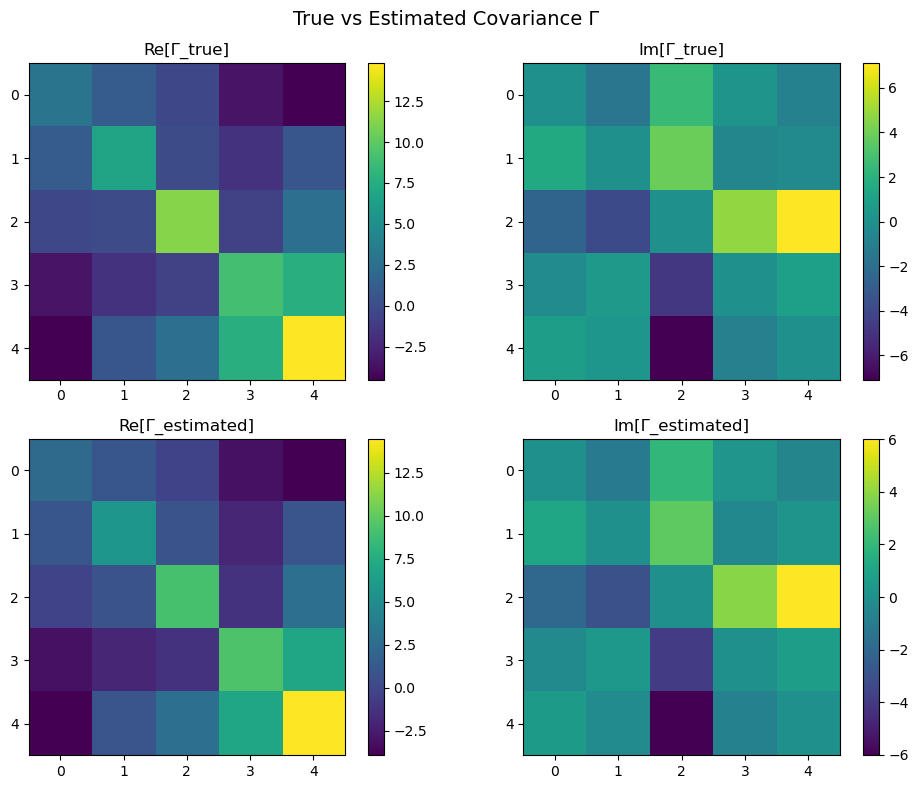

In [50]:
plot_complex_matrix_comparison(Gamma_true, Gamma_samples.mean(0))

In [537]:
func(posterior[param_name])

Array([[ 0.06086009,  0.7698526 ,  3.3729236 ,  8.653821  , 22.92403   ],
       [ 0.13915314,  0.9281727 ,  4.4300103 ,  9.034708  , 25.346012  ],
       [ 0.04014421,  0.9743442 ,  3.429594  , 10.250959  , 22.33847   ],
       ...,
       [ 0.25177884,  1.2593869 ,  3.7877488 ,  8.688044  , 24.984985  ],
       [ 0.35511982,  0.9419981 ,  4.1497235 ,  9.4206915 , 23.594791  ],
       [ 0.10837822,  0.9684602 ,  3.4496562 ,  8.007769  , 29.834911  ]],      dtype=float32)

In [ ]:
func(posterior[param_name])

Array([[0.2924258 , 1.2099845 , 4.4601693 ],
       [0.3135339 , 1.5144963 , 4.136565  ],
       [0.30246902, 1.6524634 , 4.21007   ],
       ...,
       [0.23286161, 1.5021538 , 4.1317396 ],
       [0.24552497, 1.2090564 , 3.7658548 ],
       [0.28857914, 1.1765733 , 3.9158733 ]], dtype=float32)